In [1]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')

In [2]:
#If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

#In addition, uncomment and run the following code:
# !pip install pzflow

#Intro to pzflow

#This notebook demonstrates building a normalizing flow with pzflow to learn the joint probability distribution of some 2-D data.#

#You do not need to have any previous knowledge of normalizing flows to get started with pzflow, however if you are interested, here are some good sources:

#    Eric Jang's tutorial: part 1, part 2
#    Here is a comprehensive list of papers, blogs, videos, and packages
#    Two good intro papers using Coupling Layers: NICE, Real NVP
#    The paper on Neural Spline Couplings

import jax.numpy as np
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
#from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd
import GCRCatalogs
import timeit
import numpy as onp

import seaborn as sns
#change the plot styling
sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


%matplotlib inline

/global/homes/a/agaglian/.conda/envs/pzflow/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/global/homes/a/agaglian/.conda/envs/pzflow/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [3]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')

In [19]:
# Implement a magnitude cut where LSST will never see a galaxy for each of the chunks of data 
df_set = []
for s in [10000, 10001, 10002, 10003, 10003, 10004, 10005, 10006, 10007, 10008, 10009]:
    file1 = pd.read_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_1itertest_div%i.csv"%s)
    file1_cut = file1[file1['mag_true_r_lsst'] < 28]
    df_set.append(file1_cut)
    file1_cut.to_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_1itertest_div%i_cut.tar.gz"%s,index=False)

In [21]:
# Combine chunks into one dataframe
df_comb = pd.concat(df_set, ignore_index=True)

In [27]:
# Make cuts at 0.05 > z > 3.0 to make sure we remove the edge artifacts
df_comb = df_comb[df_comb['PZflowredshift'] > 0.05]
df_comb = df_comb[df_comb['PZflowredshift'] < 3.0]

Text(0, 0.5, '$g-i$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


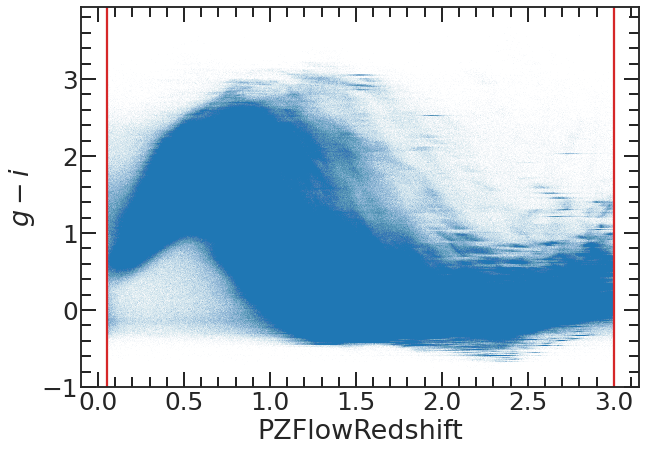

In [33]:
# Plot to see what the colors sv pzflowredshifts look like 
%matplotlib inline 
plt.figure(figsize=(10,7))
plt.plot(df_comb['PZflowredshift'], df_comb['mag_true_g_lsst'] - df_comb['mag_true_i_lsst'], 'o', ms=0.05, alpha=0.1)
plt.xlabel("PZFlowRedshift")
plt.axvline(x=0.05, c='tab:red')
plt.axvline(x=3.0, c='tab:red')
plt.ylabel(r"$g-i$")

Text(0, 0.5, 'SFRtot')

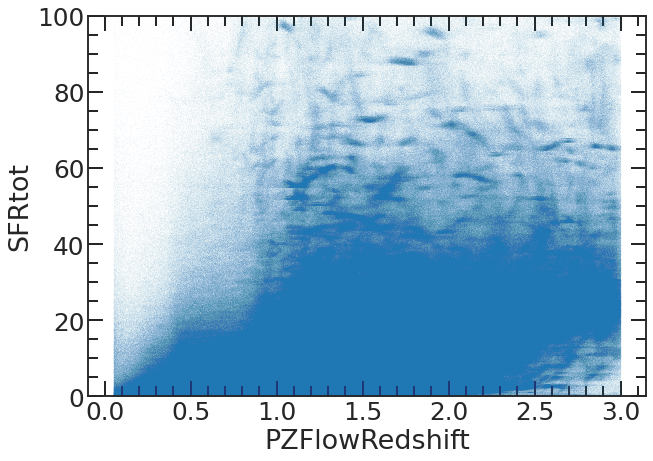

In [41]:
# And SFR (which before we were sampling with PZFlow, but are no longer)
%matplotlib inline 
plt.figure(figsize=(10,7))
plt.plot(df_comb['PZflowredshift'], df_comb['SFRtot'], 'o', ms=0.05, alpha=0.1)
plt.xlabel("PZFlowRedshift")
plt.ylim((0, 100))
plt.ylabel(r"SFRtot")

Text(0, 0.5, 'SFRtot')

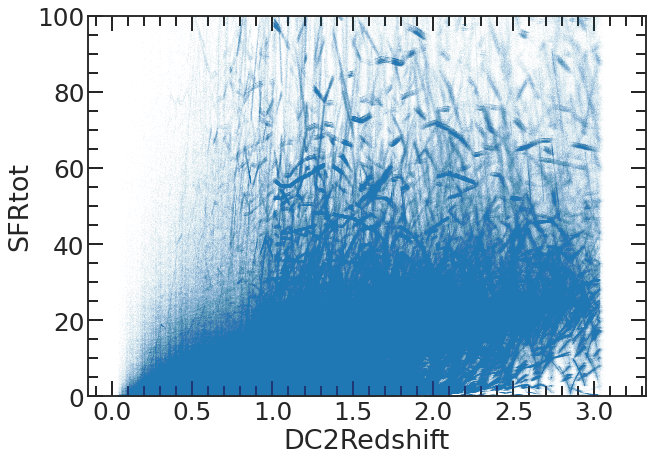

In [40]:
# And a comparison to the original (discrete) SFR vs z plot
%matplotlib inline 
plt.figure(figsize=(10,7))
plt.plot(df_comb['DC2redshift'], df_comb['SFRtot'], 'o', ms=0.05, alpha=0.1)
plt.xlabel("DC2Redshift")
plt.ylim((0, 100))
plt.ylabel(r"SFRtot")

In [43]:
#looks good, save it! 
df_comb.to_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_tenHealpix_Final.tar.gz",index=False)

In [6]:
#load the original dataframe and get the absolute magnitudes in SDSS filters from cosmoDC2 (we were using LSST apparent magnitudes for pzflow sampling)
df_comb = pd.read_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_tenHealpix_Final.tar.gz",usecols=['galaxy_id', 'PZflowredshift'])
cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4")
features = ['galaxy_id', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0']
gal = cosmo.get_quantities(features, filters=[(lambda x: np.in1d(x, df_comb['galaxy_id']), 'galaxy_id')])#, return_iterator=True)
df_sdss = pd.DataFrame(gal)
df_sdss_comb = df_sdss.merge(df_comb, on='galaxy_id', ignore_index=True)
df_sdss_comb.to_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_tenHealpix_Final_sdss.tar.gz",index=False)

In [4]:
# Load our df of SDSS photometry
df_sdss_comb = pd.read_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_tenHealpix_Final_sdss.tar.gz")

In [5]:
df_sdss_comb

,Mag_true_z_sdss_z0,galaxy_id,Mag_true_i_sdss_z0,Mag_true_g_sdss_z0,Mag_true_r_sdss_z0,DC2redshift,PZflowredshift
0,-13.178606,1250000017,-13.079893,-12.407413,-12.850061,0.014668,0.065605
1,-13.127065,1250000051,-13.055510,-12.545543,-12.870053,0.014226,0.409592
2,-13.570560,1250000057,-13.492719,-12.935266,-13.299660,0.014593,0.078224
3,-17.663464,1250000062,-17.586445,-17.007826,-17.417374,0.039114,0.055009
4,-17.188870,1250000063,-17.046010,-16.327736,-16.799519,0.044883,0.062143
...,...,...,...,...,...,...,...
40384991,-17.857735,1833340624,-17.879065,-18.033222,-17.921711,2.979277,2.986403
40384992,-18.251350,1833340664,-18.303620,-18.584510,-18.395254,2.987163,2.981422
40384993,-18.260143,1833340734,-18.274610,-18.442007,-18.322330,2.956802,2.924557
40384994,-17.455637,1833340880,-17.484997,-17.638432,-17.527246,3.011054,2.979521


In [14]:
#calculate all luminosity distances, old and new
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
dLum_old = cosmo.luminosity_distance(df_sdss_comb['DC2redshift']).to(u.pc).value
dLum_new = cosmo.luminosity_distance(df_sdss_comb['PZflowredshift']).to(u.pc).value

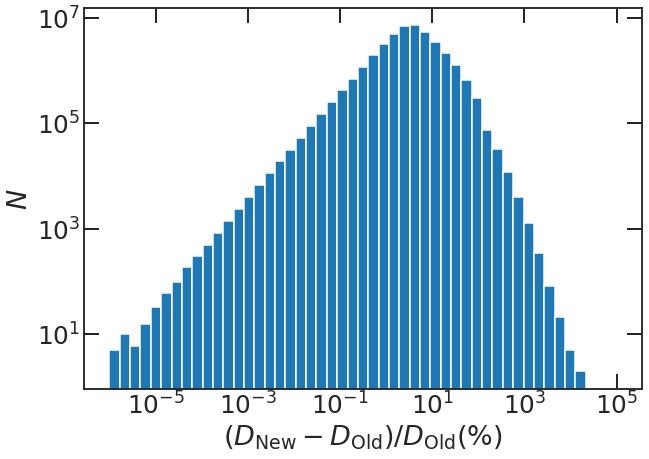

In [29]:
# Check out how our luminosity distance changes between PZFlow redshift and cosmoDC2 redshift
plt.figure(figsize=(10,7))
plt.hist(np.abs(dLum_old - dLum_new)/dLum_old*100, bins=np.logspace(-6, 5, 50))
plt.xlabel(r"$(D_{\rm New} - D_{\rm Old}) / D_{\rm Old} (\%)$")
plt.ylabel(r"$N$")
plt.xscale("log")
plt.yscale("log")

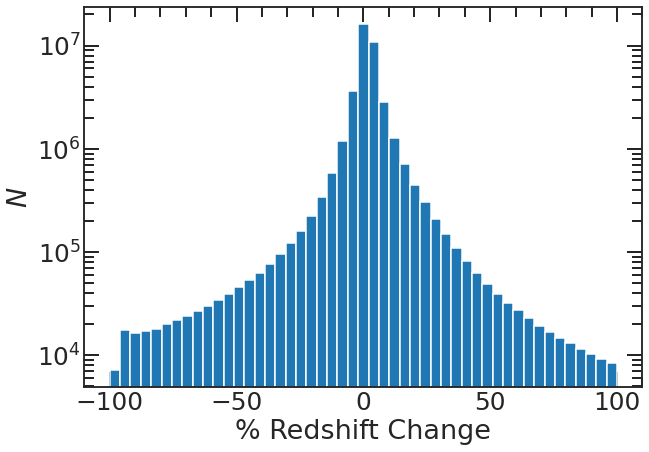

In [61]:
# Look at the % change in redshift w PZFlow
plt.figure(figsize=(10,7))
plt.hist((df_sdss_comb['PZflowredshift'] - df_sdss_comb['DC2redshift'])/df_sdss_comb['DC2redshift']*100, bins=np.linspace(-100, 100));
plt.xlabel("% Redshift Change")
plt.ylabel(r"$N$")
plt.yscale("log")

In [30]:
# Update the absolute SDSS magnitudes for matching with the GHOST catalog 
for band in ['g', 'r', 'i', 'z']:
    #Mv = m - 2.5 log[ (d/10)2 ]. 
    
    mapp = df_sdss_comb['Mag_true_%s_sdss_z0'%band] + 2.5 * np.log10((dLum_old/10)**2)
    
    #now convert back with the NEW redshift
    Mtrue = mapp - 2.5*np.log10((dLum_new/10)**2)
    
    #update the values in the dataframe
    df_sdss_comb['Mag_true_%s_sdss_z0_upd'%band] = Mtrue

In [53]:
# See how the magnitudes differ after updating
# actually by quite a bit...
df_sdss_comb[['Mag_true_g_sdss_z0', 'Mag_true_g_sdss_z0_upd']]

,Mag_true_g_sdss_z0,Mag_true_g_sdss_z0_upd
0,-12.407413,-15.741069
1,-12.545543,-20.342979
2,-12.935266,-16.681390
3,-17.007826,-17.773317
4,-16.327736,-17.061131
...,...,...
40384991,-18.033222,-18.039463
40384992,-18.584510,-18.579490
40384993,-18.442007,-18.413336
40384994,-17.638432,-17.610928


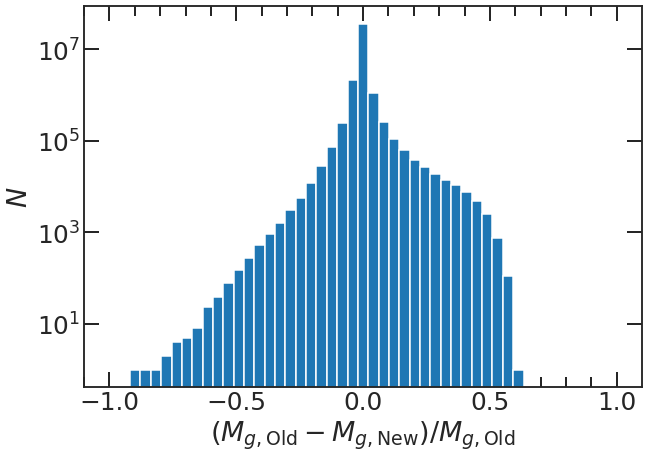

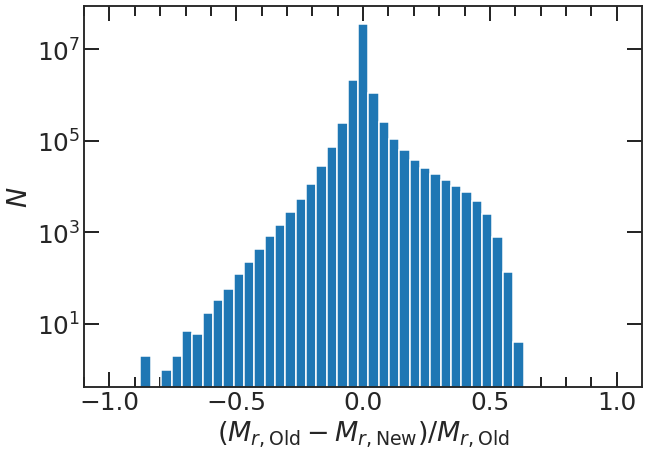

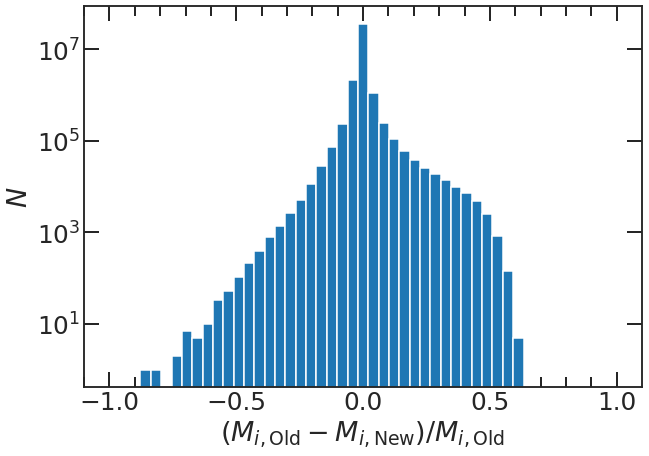

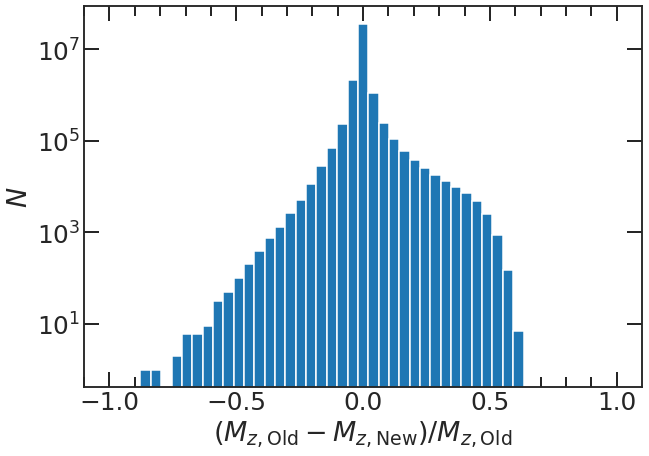

In [67]:
# Loop through and calculate the percent change in the absolute magnitude in each band
for band in ['g', 'r', 'i', 'z']:
    plt.figure(figsize=(10,7))
    plt.hist((df_sdss_comb['Mag_true_%s_sdss_z0'%band].values - df_sdss_comb['Mag_true_%s_sdss_z0_upd'%band].values)/df_sdss_comb['Mag_true_%s_sdss_z0'%band].values, bins=np.linspace(-1, 1, 50))
    plt.xlabel(r"$(M_{%s, \rm Old} - M_{%s, \rm New}) / M_{%s, \rm Old}$"%(band, band, band))
    plt.yscale("log")
    plt.ylabel(r"$N$")

In [68]:
# Update the absolute magnitudes in the catalog and then save them!
for band in ['g', 'r', 'i', 'z']:
    del df_sdss_comb['Mag_true_%s_sdss_z0'%band]
    df_sdss_comb['Mag_true_%s_sdss_z0'%band] = df_sdss_comb['Mag_true_%s_sdss_z0_upd'%band]
    del df_sdss_comb['Mag_true_%s_sdss_z0_upd'%band]
df_sdss_comb.to_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_tenHealpix_sdss_updMag.tar.gz",index=False)

In [81]:
#combine with the image catalog and get physical radius values
df_Image = pd.read_csv("/global/cscratch1/sd/agaglian/FullImageMomentsCatalog.tar.gz", usecols=['cosmoDC2_ID', 'RSQ_pixel_gal'])
df_Image['galaxy_id'] = df_Image['cosmoDC2_ID']
del df_Image['cosmoDC2_ID']
df_sdss_wImg = df_Image.merge(df_sdss_comb, on='galaxy_id')

KeyboardInterrupt: 

In [78]:
#df_sdss_wImg['RSQ_arcsec_gal'] = df_sdss_wImg['RSQ_pixel_gal']*0.2 # 0.2''/px is the scale for LSST
#dLum = cosmo.luminosity_distance(df_sdss_wImg['PZflowredshift']).to(u.pc).value #get luminosity distance again

#first take sqrt(RSQ) to get R in px, then convert to arcsec, then convert to physical distance using the following formula:
#(angle in arcsec)/206265 = d/D ---> d = (angle in arcsec * luminosity distance)/206265 (divide by 1.e3 to get kpc)
df_sdss_wImg['RSQ_kpc_gal'] = np.sqrt(df_sdss_wImg['RSQ_pixel_gal'])*0.2 * 
    cosmo.luminosity_distance(df_sdss_wImg['PZflowredshift']).to(u.pc).value/206265./1.e3

In [80]:
# get rid of this column and save the full catalog
del df_sdss_wImg['RSQ_pixel_gal']
df_sdss_wImg.to_csv("/global/cscratch1/sd/agaglian/DC2full_pzRedshifts_tenHealpix_sdss_updMag_Rkpc.tar.gz",index=False)

,RSQ_pixel_gal,galaxy_id,RSQ_arcsec_gal
0,15.784916,10940305839,3.156983
1,7.894807,10937870093,1.578961
2,-2.865943,11563663598,-0.573189
3,11.349731,10938869183,2.269946
4,3.088406,11564005688,0.617681
5,9.339836,11562943167,1.867967
6,7.316658,10937620679,1.463332
7,10.145185,11563034476,2.029037
8,4.272508,11564419932,0.854502
9,NaN,10940005465,NaN
